In [38]:
# Import Modules

# Data
import pandas as pd

# Math and visualization
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

# ML
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import classification_report, roc_curve, accuracy_score

# Python
import bisect

In [2]:
# Load the dataset
fraud_df = pd.read_csv("Fraud/Fraud_Data.csv")
ipaddress_df = pd.read_csv("Fraud/IpAddress_to_Country.csv")

In [3]:
# Preview the data and get some insight
fraud_df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,source,browser,sex,age,ip_address,class
0,22058,2015-02-24 22:55:49,2015-04-18 02:47:11,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0
1,333320,2015-06-07 20:39:50,2015-06-08 01:38:54,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0
2,1359,2015-01-01 18:52:44,2015-01-01 18:52:45,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1
3,150084,2015-04-28 21:13:25,2015-05-04 13:54:50,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0
4,221365,2015-07-21 07:09:52,2015-09-09 18:40:53,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0


In [4]:
fraud_df.describe()

,user_id,purchase_value,age,ip_address,class
count,151112.000000,151112.000000,151112.000000,1.511120e+05,151112.000000
mean,200171.040970,36.935372,33.140704,2.152145e+09,0.093646
std,115369.285024,18.322762,8.617733,1.248497e+09,0.291336
min,2.000000,9.000000,18.000000,5.209350e+04,0.000000
25%,100642.500000,22.000000,27.000000,1.085934e+09,0.000000
50%,199958.000000,35.000000,33.000000,2.154770e+09,0.000000
75%,300054.000000,49.000000,39.000000,3.243258e+09,0.000000
max,400000.000000,154.000000,76.000000,4.294850e+09,1.000000


In [5]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB


In [6]:
# Check for duplicates
print len(fraud_df["user_id"].unique())

151112


In [7]:
ipaddress_df.head()

,lower_bound_ip_address,upper_bound_ip_address,country
0,16777216.0,16777471,Australia
1,16777472.0,16777727,China
2,16777728.0,16778239,China
3,16778240.0,16779263,Australia
4,16779264.0,16781311,China


In [8]:
ipaddress_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138846 entries, 0 to 138845
Data columns (total 3 columns):
lower_bound_ip_address    138846 non-null float64
upper_bound_ip_address    138846 non-null int64
country                   138846 non-null object
dtypes: float64(1), int64(1), object(1)
memory usage: 3.2+ MB


In [9]:
# def get_country(ipaddress):
#     ip_address = ipaddress
#     country = ""
#     for i in xrange(ipaddress_df.shape[0]):
#         if ipaddress <= ipaddress_df["upper_bound_ip_address"][i] and ipaddress >= ipaddress_df["lower_bound_ip_address"][i]:
#             country = ipaddress_df["country"][i]
#     return country

In [10]:
# Code courtesy www.github.com/stasi009
class IpLookupTable(object):
    def __init__(self, df):
        """
        input: 
            df: DataFrame read from 'IpAddress_to_Country.csv'
        """
        self._nrows = df.shape[0]
        # add two more slots, one is for the ipaddress < minimum ipaddress from the file
        # another is for the ipaddress > maximum ipaddress from the file
        self._ip_lowbounds = [0 for _ in xrange(self._nrows + 2)]
        self._countries = ["Unknown" for _ in xrange(self._nrows + 2)]

        # start from 1, because 0-th cell is for ipaddress < minimal known ipaddress
        for r in xrange(1, self._nrows + 1):
            self._ip_lowbounds[r] = df.iloc[r - 1, 0]
            self._countries[r] = df.iloc[r - 1, 2]
            # assume the file is in ascending order
            assert self._ip_lowbounds[r] > self._ip_lowbounds[r - 1]

        # we cannot assign all ip> last low boundary to be that country
        # so I create a dummy ipaddress which larger than maximal known ipaddress
        self._ip_lowbounds[self._nrows + 1] = df.iloc[self._nrows - 1, 1] + 1

    def find_country(self, ip):
        index = bisect.bisect(self._ip_lowbounds, ip) - 1
        # within the range, or in last cell which doesn't have next cell
        assert ip >= self._ip_lowbounds[index] and (index == self._nrows + 1 or ip < self._ip_lowbounds[index + 1])
        return self._countries[index]

In [11]:
iplookuptable = IpLookupTable(ipaddress_df)

In [12]:
fraud_df["country"] = fraud_df["ip_address"].apply(iplookuptable.find_country)

In [13]:
fraud_df["country"].value_counts()

United States                      59222
Unknown                            20017
China                              12038
Japan                               7918
United Kingdom                      4492
Korea Republic of                   4162
Germany                             3647
France                              3163
Canada                              2981
Brazil                              2961
Italy                               1946
Australia                           1845
Netherlands                         1825
Russian Federation                  1616
India                               1310
Taiwan; Republic of China (ROC)     1237
Mexico                              1121
Sweden                              1090
Spain                               1027
South Africa                         838
Switzerland                          785
Poland                               729
Argentina                            661
Indonesia                            649
Norway          

In [14]:
fraud_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 12 columns):
user_id           151112 non-null int64
signup_time       151112 non-null object
purchase_time     151112 non-null object
purchase_value    151112 non-null int64
device_id         151112 non-null object
source            151112 non-null object
browser           151112 non-null object
sex               151112 non-null object
age               151112 non-null int64
ip_address        151112 non-null float64
class             151112 non-null int64
country           151112 non-null object
dtypes: float64(1), int64(4), object(7)
memory usage: 13.8+ MB


In [15]:
# Let's do some feature engineering.

# Time difference between purchase and signup
fraud_df["signup_time"] = pd.to_datetime(fraud_df["signup_time"]) # Changes dtype object to datetime
fraud_df["purchase_time"] = pd.to_datetime(fraud_df["purchase_time"])
fraud_df["interval_btw_signup_purchase"] = (fraud_df["purchase_time"] - fraud_df["signup_time"]).dt.total_seconds()
fraud_df.drop(["signup_time", "purchase_time"], axis=1, inplace=True)

In [16]:
fraud_df.head()

,user_id,purchase_value,device_id,source,browser,sex,age,ip_address,class,country,interval_btw_signup_purchase
0,22058,34,QVPSPJUOCKZAR,SEO,Chrome,M,39,7.327584e+08,0,Japan,4506682.0
1,333320,16,EOGFQPIZPYXFZ,Ads,Chrome,F,53,3.503114e+08,0,United States,17944.0
2,1359,15,YSSKYOSJHPPLJ,SEO,Opera,M,53,2.621474e+09,1,United States,1.0
3,150084,44,ATGTXKYKUDUQN,SEO,Safari,M,41,3.840542e+09,0,Unknown,492085.0
4,221365,39,NAUITBZFJKHWW,Ads,Safari,M,45,4.155831e+08,0,United States,4361461.0


In [17]:
# For each device id how many different users
print(fraud_df[["device_id", "user_id"]].groupby(["device_id"], as_index=False).count())

            device_id  user_id
0       AAALBGNHHVMKG        1
1       AAAWIHVCQELTP        1
2       AAAXJHWCLISKY        1
3       AAAXXOZJRZRAO       11
4       AABFGRPBQHWFQ        1
5       AABGCAPIYUWNC        1
6       AABJEESQPJHDQ        1
7       AABNLBQBKMWRG        1
8       AABOMYDURXEQT        1
9       AABOOVEJUXMKC        1
10      AABOYHXAZBTLZ        1
11      AABQZGLRSEYGR        1
12      AABVEORDXZXUO        1
13      AABZHGGYUMVEQ        1
14      AACBIMMVQIFWW        1
15      AACEEKSUWDCSU        1
16      AACIHTWABTEMZ        1
17      AACOSZDJHOJIZ        1
18      AACRSKFMHVMCE        1
19      AACTNBYQYAVPE        1
20      AACUHRZNDEHGI        1
21      AACYYBUHPLDWT        1
22      AADEPZVZDTXGA        1
23      AADGMPYOPXXCX        1
24      AADHZIOUTNGHW        1
25      AADMHINGHICLN        1
26      AADOZLHNCJMMS        1
27      AADSJJXNALPUV        1
28      AADTALFGPPJOP        1
29      AADWLKVTMKVDI        1
...               ...      ...
137926  

In [18]:
# Let's do the same thing for ip address
print(fraud_df[["ip_address", "user_id"]].groupby(["ip_address"], as_index=False).count())

          ip_address  user_id
0       5.209350e+04        1
1       9.344714e+04        1
2       1.058185e+05        1
3       1.175667e+05        1
4       1.314238e+05        1
5       1.551304e+05        1
6       1.553991e+05        1
7       1.591198e+05        1
8       1.663268e+05        1
9       2.079996e+05        1
10      2.114294e+05        1
11      3.063559e+05        1
12      3.464139e+05        1
13      3.709400e+05        1
14      3.711868e+05        1
15      4.289369e+05        1
16      5.042214e+05        1
17      5.079557e+05        1
18      5.414189e+05        1
19      5.479740e+05        1
20      5.504003e+05        1
21      5.601484e+05        1
22      5.972978e+05        1
23      6.058097e+05        1
24      6.100372e+05        1
25      6.626424e+05        1
26      6.663332e+05        1
27      7.125129e+05        1
28      7.353541e+05        1
29      7.944125e+05        1
...              ...      ...
143482  4.293877e+09        1
143483  4.

In [19]:
no_devices_shared = fraud_df["device_id"].value_counts()
fraud_df["no_devices_shared"] = fraud_df["device_id"].map(no_devices_shared) # Tried apply but got an error. 
                                                                             # Series not callable
fraud_df.drop(["device_id"], axis=1, inplace=True)

In [20]:
no_ip_shared = fraud_df["ip_address"].value_counts()
fraud_df["no_ip_shared"] = fraud_df["ip_address"].map(no_ip_shared)
del fraud_df["ip_address"]

In [21]:
no_country_shared = fraud_df["country"].value_counts()
fraud_df["no_country_shared"] = fraud_df["country"].map(no_country_shared)
del fraud_df["country"]

In [22]:
# Let's get dummies for sex, browser, and source
fraud_df = pd.get_dummies(fraud_df, columns=["sex", "browser", "source"])

In [23]:
fraud_df.drop(["sex_F", "browser_Opera", "source_Direct" ], axis=1, inplace=True)

In [24]:
# One final glance of the data set
fraud_df = fraud_df.set_index("user_id")
fraud_df.head()

,purchase_value,age,class,interval_btw_signup_purchase,no_devices_shared,no_ip_shared,no_country_shared,sex_M,browser_Chrome,browser_FireFox,browser_IE,browser_Safari,source_Ads,source_SEO
user_id,,,,,,,,,,,,,,
22058,34,39,0,4506682.0,1,1,7918,1,1,0,0,0,0,1
333320,16,53,0,17944.0,1,1,59222,0,1,0,0,0,1,0
1359,15,53,1,1.0,12,12,59222,1,0,0,0,0,0,1
150084,44,41,0,492085.0,1,1,20017,1,0,0,0,1,0,1
221365,39,45,0,4361461.0,1,1,59222,1,0,0,0,1,1,0


In [25]:
# Build the model

# Define data
X = fraud_df
y = X.pop("class")

In [27]:
# Split the data into training and test set
seed = 999
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=seed)
y.mean(), y_train.mean(), y_test.mean()

(0.093645772671925462, 0.093150279026124744, 0.094651773718090124)

In [29]:
model = RandomForestClassifier(n_estimators=100, max_features=3)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=3, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [30]:
model.score(X_train, y_train)

0.99990122969035511

In [31]:
model.score(X_test, y_test)

0.95451902059478211

In [32]:
y_pred = model.predict(X_test)
print classification_report(y_true=y_test, y_pred=y_pred)

             precision    recall  f1-score   support

          0       0.95      1.00      0.98     45147
          1       0.97      0.54      0.69      4720

avg / total       0.96      0.95      0.95     49867



In [34]:
fpr,tpr,thresholds = roc_curve(y_test,y_pred)

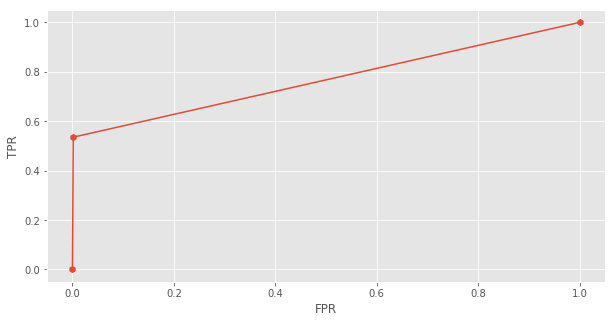

In [39]:
plt.figure(figsize=(10,5))
plt.plot(fpr,tpr,marker='h')
plt.xlabel("FPR")
plt.ylabel("TPR")

/home/shreeranga/PP/Exp/venvs/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: sort is deprecated, use sort_values(inplace=True) for INPLACE sorting
  app.launch_new_instance()


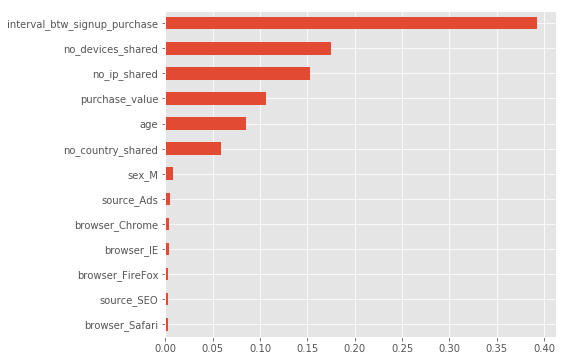

In [40]:
# Let's check the variable importance
imp_features = pd.Series(model.feature_importances_, index = X.columns)
imp_features.sort()
imp_features.plot(kind="barh", figsize=(7,6))